   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 7.7 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


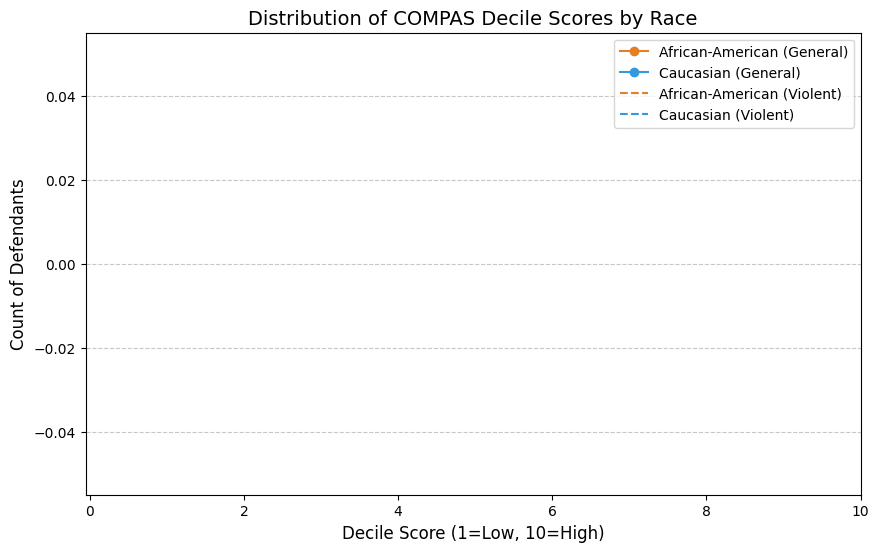

In [2]:
# Part 3: Practical Audit
# This script performs a comprehensive fairness audit on the COMPAS dataset,
# analyzing both general and violent recidivism scores using the AI Fairness 360 library.
# The script automatically installs any missing dependencies.
!pip install aif360 pandas matplotlib requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import io
import requests
import subprocess
import sys
from matplotlib.ticker import MaxNLocator

# This function programmatically installs required packages,
# making the script self-contained and runnable in any Python environment.
def install_packages():
    """Installs required Python packages if they are not already present."""
    packages = ['aif360', 'pandas', 'matplotlib', 'requests']
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"Finished installing {package}.")

install_packages()

def load_and_preprocess_data(file_url, prediction_column, label_column):
    """
    Loads and pre-processes a COMPAS dataset from a given URL.

    Args:
        file_url (str): The URL of the CSV file.
        prediction_column (str): The name of the column containing the risk score text.
        label_column (str): The name of the column containing the ground truth label.

    Returns:
        pd.DataFrame: The cleaned and pre-processed DataFrame.
    """
    try:
        s = requests.get(file_url).content
        df = pd.read_csv(io.StringIO(s.decode('utf-8')))
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from the URL: {e}")
        return None

    # --- Data Pre-processing based on ProPublica's methodology ---
    df = df[df['is_recid'] != -1]
    df = df[df['c_charge_degree'] != 'O']
    df = df[(df['days_b_screening_arrest'] >= -30) & (df['days_b_screening_arrest'] <= 30)]
    df.dropna(inplace=True)

    # Map the score text to a binary prediction label
    df['pred_label'] = df[prediction_column].apply(lambda x: 1 if x in ['High', 'Medium'] else 0)

    # Rename columns to a standardized format for aif360
    df.rename(columns={prediction_column: 'score_text', label_column: 'true_label'}, inplace=True)
    return df

def run_fairness_audit_and_plot(general_df, violent_df):
    """
    Performs fairness audits and generates a combined figure with all plots.
    """
    if general_df is None or violent_df is None:
        print("Skipping audit due to data loading error.")
        return

    # --- Calculate metrics for General Recidivism ---
    general_unprivileged_group = [{'race': 'African-American'}]
    general_privileged_group = [{'race': 'Caucasian'}]

    general_dataset_orig = BinaryLabelDataset(
        df=general_df,
        label_names=['true_label'],
        protected_attribute_names=['race'],
        privileged_protected_attributes=[['Caucasian']],
        favorable_label=0,  # 0 for no recidivism
        unfavorable_label=1,  # 1 for recidivism
    )
    general_dataset_pred = general_dataset_orig.copy()
    general_dataset_pred.labels = general_df['pred_label'].values.reshape(-1, 1)
    general_metric = ClassificationMetric(
        general_dataset_orig,
        general_dataset_pred,
        unprivileged_groups=general_unprivileged_group,
        privileged_groups=general_privileged_group
    )

    general_fpr_unprivileged = general_metric.false_positive_rate(privileged=False)
    general_fpr_privileged = general_metric.false_positive_rate(privileged=True)
    general_false_positives = general_df[(general_df['pred_label'] == 1) & (general_df['true_label'] == 0)]
    general_fp_by_race = general_false_positives['race'].value_counts().reindex(['African-American', 'Caucasian'], fill_value=0)

    # --- Calculate metrics for Violent Recidivism ---
    violent_unprivileged_group = [{'race': 'African-American'}]
    violent_privileged_group = [{'race': 'Caucasian'}]

    violent_dataset_orig = BinaryLabelDataset(
        df=violent_df,
        label_names=['true_label'],
        protected_attribute_names=['race'],
        privileged_protected_attributes=[['Caucasian']],
        favorable_label=0,  # 0 for no recidivism
        unfavorable_label=1,  # 1 for recidivism
    )
    violent_dataset_pred = violent_dataset_orig.copy()
    violent_dataset_pred.labels = violent_df['pred_label'].values.reshape(-1, 1)
    violent_metric = ClassificationMetric(
        violent_dataset_orig,
        violent_dataset_pred,
        unprivileged_groups=violent_unprivileged_group,
        privileged_groups=violent_privileged_group
    )

    violent_fpr_unprivileged = violent_metric.false_positive_rate(privileged=False)
    violent_fpr_privileged = violent_metric.false_positive_rate(privileged=True)
    violent_false_positives = violent_df[(violent_df['pred_label'] == 1) & (violent_df['true_label'] == 0)]
    violent_fp_by_race = violent_false_positives['race'].value_counts().reindex(['African-American', 'Caucasian'], fill_value=0)

    # --- Data Visualization: Combined Bar Charts ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('COMPAS Fairness Audit: Comparison of Recidivism Scores by Race', fontsize=16, y=1.02)
    plt.tight_layout(pad=3.0)

    # General Recidivism False Positive Rate
    labels = ['African-American', 'Caucasian']
    fpr_values_general = [general_fpr_unprivileged, general_fpr_privileged]
    axes[0, 0].bar(labels, fpr_values_general, color=['#e67e22', '#3498db'])
    axes[0, 0].set_title('General Recidivism FPR')
    axes[0, 0].set_ylabel('False Positive Rate')
    axes[0, 0].set_ylim(0, 0.5)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0, 0].text(0, fpr_values_general[0] + 0.02, f"{fpr_values_general[0]:.4f}", ha='center', fontsize=10)
    axes[0, 0].text(1, fpr_values_general[1] + 0.02, f"{fpr_values_general[1]:.4f}", ha='center', fontsize=10)

    # Violent Recidivism False Positive Rate
    fpr_values_violent = [violent_fpr_unprivileged, violent_fpr_privileged]
    axes[0, 1].bar(labels, fpr_values_violent, color=['#e67e22', '#3498db'])
    axes[0, 1].set_title('Violent Recidivism FPR')
    axes[0, 1].set_ylabel('False Positive Rate')
    axes[0, 1].set_ylim(0, 0.5)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0, 1].text(0, fpr_values_violent[0] + 0.02, f"{fpr_values_violent[0]:.4f}", ha='center', fontsize=10)
    axes[0, 1].text(1, fpr_values_violent[1] + 0.02, f"{fpr_values_violent[1]:.4f}", ha='center', fontsize=10)

    # General Recidivism False Positive Count
    axes[1, 0].bar(general_fp_by_race.index, general_fp_by_race.values, color=['#e67e22', '#3498db'])
    axes[1, 0].set_title('General Recidivism FP Count')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1, 0].text(0, general_fp_by_race['African-American'] + 20, f"{general_fp_by_race['African-American']}", ha='center', fontsize=10)
    axes[1, 0].text(1, general_fp_by_race['Caucasian'] + 20, f"{general_fp_by_race['Caucasian']}", ha='center', fontsize=10)

    # Violent Recidivism False Positive Count
    axes[1, 1].bar(violent_fp_by_race.index, violent_fp_by_race.values, color=['#e67e22', '#3498db'])
    axes[1, 1].set_title('Violent Recidivism FP Count')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1, 1].text(0, violent_fp_by_race['African-American'] + 20, f"{violent_fp_by_race['African-American']}", ha='center', fontsize=10)
    axes[1, 1].text(1, violent_fp_by_race['Caucasian'] + 20, f"{violent_fp_by_race['Caucasian']}", ha='center', fontsize=10)

    plt.show()

    # --- Data Visualization: Decile Scores ---
    plt.figure(figsize=(10, 6))

    # Plot for General Recidivism
    general_scores_aa = general_df[general_df['race'] == 'African-American']['decile_score'].value_counts().sort_index()
    general_scores_ca = general_df[general_df['race'] == 'Caucasian']['decile_score'].value_counts().sort_index()
    plt.plot(general_scores_aa.index, general_scores_aa.values, label='African-American (General)', color='#e67e22', marker='o')
    plt.plot(general_scores_ca.index, general_scores_ca.values, label='Caucasian (General)', color='#3498db', marker='o')

    # Plot for Violent Recidivism
    violent_scores_aa = violent_df[violent_df['race'] == 'African-American']['v_decile_score'].value_counts().sort_index()
    violent_scores_ca = violent_df[violent_df['race'] == 'Caucasian']['v_decile_score'].value_counts().sort_index()
    plt.plot(violent_scores_aa.index, violent_scores_aa.values, label='African-American (Violent)', color='#e67e22', linestyle='--')
    plt.plot(violent_scores_ca.index, violent_scores_ca.values, label='Caucasian (Violent)', color='#3498db', linestyle='--')

    plt.title('Distribution of COMPAS Decile Scores by Race', fontsize=14)
    plt.xlabel('Decile Score (1=Low, 10=High)', fontsize=12)
    plt.ylabel('Count of Defendants', fontsize=12)
    plt.xticks(np.arange(1, 11, 1))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# --- Main Script Execution ---

# 1. Load data for both general and violent recidivism
general_recidivism_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
violent_recidivism_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv"
general_df = load_and_preprocess_data(general_recidivism_url, 'score_text', 'two_year_recid')
violent_df = load_and_preprocess_data(violent_recidivism_url, 'v_score_text', 'is_violent_recid')

# 2. Run the audit and plot all figures
run_fairness_audit_and_plot(general_df, violent_df)